In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import dask

import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry

import fiona
import rasterio.features
from osgeo import gdal, ogr
import os
from rsgislib.segmentation import segutils
from rasterstats import zonal_stats

#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools, BandIndices
from load_data import load_data
from transform_tuple import transform_tuple
from imageSeg import imageSeg
from query_from_shp import query_from_shp


# %load_ext autoreload
# %autoreload 2

Set up query and analysis parameters
Here we set a centroid for the area we want to compare, and set up CRS, resolution and resampling that will be applied to both collectiondatasets. The values below extract both collections to match the collection upgrade CRS and resolution (UTM zone 56 S and 30m pixels).

In [3]:
# where is your data and results folder?
data = 'data/'
results = 'results/'

#Input your area of interest's name, coords, and 
#the year you're interested in?
AOI = 'collectionTest'
year = 'Summer2017-18'
# Centre point of spatial query
lat, lon = -35.969, 145.394
time_period = ('2017-11-01', '2018-03-31')

# Desired output resolution and projection for both datasets
output_crs = 'EPSG:28355'
output_resolution = (30, 30)
output_resamp_continuous = 'bilinear'
output_resamp_categorical = 'nearest'

# Bands/measurements to load
collectionupgrade_bands = ['nbart_red','nbart_nir']
currentcollection_bands = ['red', 'nir']

# Set up query
query = {'lon': (lon - 0.15, lon + 0.15),
         'lat': (lat - 0.15, lat + 0.15),
         'time': time_period}

# Connect to current collection and collection upgrade databases
dc_ard = datacube.Datacube(config='/g/data1a/u46/users/cb3058/datacube.conf', env='datacube_upgrade')
dc = datacube.Datacube()

# Preview spatial query
# DEAPlotting.display_map(x=query['lon'], y=query['lat'], crs='EPSG:4326')

#What thresholds should I use?
threshold = 0.8

In [4]:
#Creating a folder to keep things neat
directory = results + AOI + "_" + year
if not os.path.exists(directory):
    os.mkdir(directory)

results = results + AOI + "_" + year + "/"


## Load in collection upgrade data (DEA Landsat Collection 3)

In [5]:
xarray_dict = {}

# Iterate through each sensor
for sensor in ['ls8']:

    # Load data 
    landsat_ds = dc_ard.load(product = f'{sensor}_ard', 
                             measurements = collectionupgrade_bands,
                             output_crs = output_crs,
                             resolution = output_resolution,
                             resampling = output_resamp_continuous,
                             align=(output_resolution[0]/2.0, output_resolution[1]/2.0),
                             group_by = 'solar_day', 
                             **query)
    
    # Load PQ data seperately (this enables using a different resampling method on 
    # continuous surface reflectance values vs categorical fmask/PQ values)
    landsat_pq = dc_ard.load(product = f'{sensor}_ard', 
                             measurements = ['fmask'],
                             output_crs = output_crs,
                             resolution = output_resolution,
                             resampling = output_resamp_categorical,
                             align=(output_resolution[0]/2.0, output_resolution[1]/2.0),
                             group_by = 'solar_day', 
                             **query)

    # Identify pixels with valid data: no nodata AND no cloud AND no cloud shadow
    good_quality = ((landsat_pq.fmask != 0) & 
                    (landsat_pq.fmask != 2) & 
                    (landsat_pq.fmask != 3))

    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    landsat_ds = landsat_ds.where(good_quality)

    # Add to list
    xarray_dict[sensor] = landsat_ds

# Concatenate multiple sensors into one dataset
landsat_collectionupgrade = xr.concat(xarray_dict.values(), dim='time')
landsat_collectionupgrade = landsat_collectionupgrade.sortby('time')
landsat_collectionupgrade

<xarray.Dataset>
Dimensions:    (time: 19, x: 921, y: 1126)
Coordinates:
  * y          (y) float64 6.001e+06 6.001e+06 6.001e+06 ... 6.035e+06 6.035e+06
  * x          (x) float64 3.414e+05 3.414e+05 3.414e+05 ... 3.689e+05 3.69e+05
  * time       (time) datetime64[ns] 2017-11-06T00:03:20.596750 ... 2018-03-30T00:02:31.306882
Data variables:
    nbart_red  (time, y, x) float64 1.065e+03 1.074e+03 ... 455.0 497.0
    nbart_nir  (time, y, x) float64 2.236e+03 2.2e+03 ... 2.683e+03 2.671e+03
Attributes:
    crs:      EPSG:28355

## Load in current collection data (DEA Landsat Collection 2)

In [6]:
xarray_dict = {}

for sensor in ['ls8']:

    # Load data 
    landsat_ds = dc.load(product = f'{sensor}_nbart_albers', 
                         measurements = currentcollection_bands,
                         output_crs = output_crs,
                         resolution = output_resolution,
                         resampling = output_resamp_continuous,
                         group_by = 'solar_day', 
                         **query)

    # Load PQ data 
    landsat_pq = dc.load(product = f'{sensor}_pq_albers', 
                         measurements = ['pixelquality'],
                         output_crs = output_crs,
                         resolution = output_resolution,
                         resampling = output_resamp_categorical,
                         group_by = 'solar_day', 
                         **query)                       

    # Filter to subset of Landsat observations that have matching PQ data 
    time = (landsat_ds.time - landsat_pq.time).time
    landsat_ds = landsat_ds.sel(time=time)
    landsat_pq = landsat_pq.sel(time=time)

    # Create PQ mask
    good_quality = masking.make_mask(landsat_pq.pixelquality,
                                     cloud_acca='no_cloud',
                                     cloud_shadow_acca='no_cloud_shadow',
                                     cloud_shadow_fmask='no_cloud_shadow',
                                     cloud_fmask='no_cloud',
                                     blue_saturated=False,
                                     green_saturated=False,
                                     red_saturated=False,
                                     nir_saturated=False,
                                     swir1_saturated=False,
                                     swir2_saturated=False,
                                     contiguous=True) 
    
    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    landsat_ds = landsat_ds.where(good_quality)

    # Add result to dict
    xarray_dict[sensor] = landsat_ds

# Concatenate multiple sensors into one dataset
landsat_currentcollection = xr.concat(xarray_dict.values(), dim='time')
landsat_currentcollection = landsat_ds.sortby('time')
landsat_currentcollection

<xarray.Dataset>
Dimensions:  (time: 19, x: 921, y: 1125)
Coordinates:
  * time     (time) datetime64[ns] 2017-11-06T00:03:20 ... 2018-03-30T00:02:31
  * y        (y) float64 6.001e+06 6.001e+06 6.001e+06 ... 6.035e+06 6.035e+06
  * x        (x) float64 3.414e+05 3.414e+05 3.414e+05 ... 3.689e+05 3.69e+05
Data variables:
    red      (time, y, x) float64 1.105e+03 1.091e+03 1.079e+03 ... 411.0 490.0
    nir      (time, y, x) float64 2.368e+03 2.316e+03 ... 2.691e+03 2.772e+03
Attributes:
    crs:      EPSG:28355

In [7]:
# Round both dataset timestamps to daily because both datasets have different timestamps
landsat_collectionupgrade.coords['time'] = landsat_collectionupgrade.time.astype('datetime64[D]')
landsat_currentcollection.coords['time'] = landsat_currentcollection.time.astype('datetime64[D]')

# Rename current collection bands to match collection upgrade
band_rename_dict = {'red': 'nbart_red', 
                    'nir': 'nbart_nir' }
landsat_currentcollection.rename(band_rename_dict, inplace=True)

# Unfortunately due to the different pixel definitions for the DEA Landsat Collections 2 and 3,
# the same spatial query can result in a different number of rows and columns. Because of this,
# the only way we can directly compare the two collections is to force them to match by resampling
# one to the rows x columns of the other. This will introduce some uncertainty in the comparison.
landsat_currentcollection = landsat_currentcollection.interp_like(landsat_collectionupgrade)

## Run MaxNDVI irrigated extent algorithm on both datasets

In [8]:
#band indices calculation
def ndvi_func(nir, red):
    return ((nir - red)/(nir + red))

def ndvi_ufunc(ds):
    return xr.apply_ufunc(
        ndvi_func, ds.nbart_nir, ds.nbart_red,
        dask='parallelized',
        output_dtypes=[float])

print("calculating NDVI")
NDVI_landsat = ndvi_ufunc(landsat_currentcollection)

#calculate per pixel summary stats
print("calculating summary stats")
NDVI_max = NDVI_landsat.groupby('x','y').max('time').rename('NDVI_max')
# NDVI_max = NDVI_max.chunk({'x':1000, 'y':1000})

transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=28355)
print("exporting MaxNDVI GTiff")
SpatialTools.array_to_geotiff(results + AOI + "_" + year + ".tif",
              NDVI_max.values, geo_transform = transform, 
              projection = projection, nodata_val=-9999.)

# ## Image Segmentation

# setup input filename
InputNDVIStats = results + AOI + "_" + year + ".tif"
KEAFile = results + AOI + '_' + year + '.kea'
SegmentedKEAFile = results + AOI + '_' + year + '_sheperdSEG.kea'
SegmentedTiffFile = results + AOI + '_' + year + '_sheperdSEG.tif'
SegmentedPolygons = results + AOI + '_' + year + '_SEGpolygons.shp'
print("calculating imageSegmentation")
imageSeg(InputNDVIStats, KEAFile, SegmentedKEAFile, SegmentedTiffFile, SegmentedPolygons, epsg='28355')

# ### Zonal Statistics & filtering

gdf = gpd.read_file(results + AOI + '_' + year + '_SEGpolygons.shp')
#calculate zonal mean of NDVI
print("Calculating zonal stats over the polygons")
gdf['mean'] = pd.DataFrame(zonal_stats(vectors=gdf['geometry'], raster=InputNDVIStats, stats='mean'))['mean']
#calculate area of polygons
gdf['area'] = gdf['geometry'].area
#filter by area and mean NDVI
highNDVI = gdf['mean'] >= threshold
smallArea = gdf['area'] <= 5500000
gdf = gdf[highNDVI & smallArea]
#export shapefile
gdf.to_file(results + AOI + "_" + year + "_Irrigated.shp")

#get the transform and projection of our gtiff
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=28355)
#find the width and height of the xarray dataset we want to mask
width,height = NDVI_max.shape
# rasterize vector
gdf_raster = SpatialTools.rasterize_vector(results + AOI + "_" + year + "_Irrigated.shp",
                                           height, width, transform, projection, raster_path=None)
# Mask the xarray
NDVI_max_Irrigated = NDVI_max.where(gdf_raster)

#remove areas below our threshold that are at the edges of the rasterized polygons
NDVI_max_Irrigated = NDVI_max_Irrigated.where(NDVI_max_Irrigated >= threshold)

#What is the area of irrigation?
ones = np.count_nonzero(~np.isnan(NDVI_max_Irrigated.values))
area = (ones*(25*25)) / 1000000
print("Around " + AOI + " during " + str(year) + ", " + str(area) + " km2 was under irrigated cultivation")

calculating NDVI
calculating summary stats
exporting MaxNDVI GTiff
calculating imageSegmentation
converting tif to a kea file...
Stretch Input Image


error: Images do not overlap in the X axis

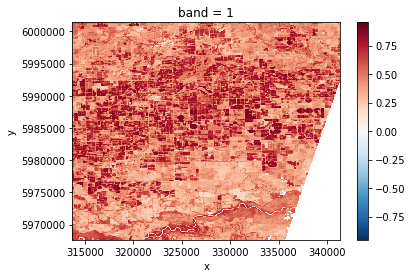

In [23]:
a = xr.open_rasterio(InputNDVIStats)
a.plot()

In [25]:
landsat_collectionupgrade

<xarray.Dataset>
Dimensions:    (time: 19, x: 921, y: 1126)
Coordinates:
  * y          (y) float64 6.001e+06 6.001e+06 6.001e+06 ... 6.035e+06 6.035e+06
  * x          (x) float64 3.414e+05 3.414e+05 3.414e+05 ... 3.689e+05 3.69e+05
  * time       (time) datetime64[ns] 2017-11-06 2017-11-13 ... 2018-03-30
Data variables:
    nbart_red  (time, y, x) float64 1.065e+03 1.074e+03 ... 455.0 497.0
    nbart_nir  (time, y, x) float64 2.236e+03 2.2e+03 ... 2.683e+03 2.671e+03
Attributes:
    crs:      EPSG:28355

In [20]:
b = xr.open_rasterio(KEAFile)
b

<xarray.DataArray (band: 1, y: 1126, x: 921)>
[1037046 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.001e+06 6.001e+06 6.001e+06 ... 5.968e+06 5.968e+06
  * x        (x) float64 3.414e+05 3.413e+05 3.413e+05 ... 3.138e+05 3.138e+05
Attributes:
    transform:   (-30.0, 0.0, 341370.0, 0.0, -30.0, 6001410.0)
    crs:         +init=epsg:28355
    res:         (-30.0, 30.0)
    is_tiled:    1
    nodatavals:  (-9999.0,)

## Compute difference

In [ ]:
# Subtract collection upgrade 
collection_diffs = landsat_currentcollection - landsat_collectionupgrade

# Plot differences for each band. Blue = current collection was higher than collection upgrade
collection_diffs.to_array().plot(col='variable', row='time', size=4, vmin=-200, vmax=200, cmap='RdBu', aspect=1)

## Testing the OEH workflow

In [ ]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import dask
import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry
import rasterio.features
from osgeo import gdal, ogr
import os
from rsgislib.segmentation import segutils
from rasterstats import zonal_stats

#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools, BandIndices
from load_data import load_data
from transform_tuple import transform_tuple
from imageSeg import imageSeg
from query_from_shp import query_from_shp

In [26]:
pwd

'/g/data1a/r78/cb3058/dea-notebooks/ICE_project'

In [ ]:
############
#User Inputs
############

# where are the dcStats MaxNDVI tifs?
MaxNDVItiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/summer/previous_run/testing_mosaics/ndvi_max/"

# where are the dcStats NDVIArgMaxMin tifs?
NDVIArgMaxMintiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/New folder/argmaxndvi/"

#Is there an irrigatable area shapefile we're using for masking?
irrigatable_area = False
irrigatable_area_shp_fpath = "/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/NSW_OEH_irrigated_2013.shp"

#is there a shapefile we're using for clipping the extent? e.g. just the northern basins
clip_extent = True
northernBasins_shp = "/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/northern_basins.shp"

# where should I put the results?
results = '/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/summer/previous_run/testing_mosaics/results/'

#what season are we processing?
season = 'Summer'

#Input your area of interest's name
AOI = 'smalltest'

#What thresholds should I use for NDVI?
threshold = 0.8

#-----------------------------------------

#script proper------------------------------

#loop through raster files and do the analysis
maxNDVItiffFiles = os.listdir(MaxNDVItiffs)
# NDVIArgMaxMintiffFiles = os.listdir(NDVIArgMaxMintiffs)

for tif in maxNDVItiffFiles:
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("starting processing of " + tif)
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    results_ = results
    if season == 'Summer':
        year = tif[9:13]
        nextyear = str(int(year) + 1)[2:] 
        year = year + "_" + nextyear
        year = season + year
        argmaxminyear = "NDVIArgMaxMin_" + year[6:10] + "1101.tif" 
    if season == 'Winter':
        year = tif[7:11]
        year = season + year
        argmaxminyear = "NDVIArgMaxMin_" + year[6:10] + "0501.tif" 

    #Creating a folder to keep things neat
    directory = results_ + AOI + "_" + year
    if not os.path.exists(directory):
        os.mkdir(directory)

    results_ = results_ + AOI + "_" + year + "/"

    # set up input filename
    InputNDVIStats = MaxNDVItiffs + tif
    KEAFile = results_ + AOI + '_' + year + '.kea'
    SegmentedKEAFile = results_ + AOI + '_' + year + '_sheperdSEG.kea'
    SegmentedTiffFile = results_ + AOI + '_' + year + '_sheperdSEG.tif'
    SegmentedPolygons = results_ + AOI + '_' + year + '_SEGpolygons.shp'
    
    print("calculating imageSegmentation")
    imageSeg(InputNDVIStats, KEAFile, SegmentedKEAFile, SegmentedTiffFile, SegmentedPolygons, minPxls=100)

    gdf = gpd.read_file(results_ + AOI + '_' + year + '_SEGpolygons.shp')
    
    #calculate zonal mean of NDVI
    print("calculating zonal stats")
    gdf['mean'] = pd.DataFrame(zonal_stats(vectors=gdf['geometry'], raster=InputNDVIStats, stats='mean'))['mean']
    #calculate area of polygons
    gdf['area'] = gdf['geometry'].area
    #filter by area and mean NDVI
    highNDVI = gdf['mean'] >= threshold
    smallArea = gdf['area'] <= 5500000
    gdf = gdf[highNDVI & smallArea]
    #export shapefile
    gdf.to_file(results_ + AOI + "_" + year + "_Irrigated.shp")
    
    print('performing masking and raster math')
    NDVI_max = xr.open_rasterio(InputNDVIStats).squeeze()
    #get the transform and projection of our gtiff
    transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
    #find the width and height of the xarray dataset we want to mask
    width,height = NDVI_max.shape
    # rasterize vector
    gdf_raster = SpatialTools.rasterize_vector(results_ + AOI + "_" + year + "_Irrigated.shp",
                                               height, width, transform, projection, raster_path=None)
    # Mask the xarray
    NDVI_max_Irrigated = NDVI_max.where(gdf_raster)

    #remove areas below our threshold that are at the edges of the rasterized polygons
    NDVI_max_Irrigated = NDVI_max_Irrigated.where(NDVI_max_Irrigated >= threshold)
    
    print('exporting the irrigatation Gtiff')
    SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_Irrigated.tif",
                  NDVI_max_Irrigated.values,
                  geo_transform = transform, 
                  projection = projection, 
                  nodata_val=-9999)
    
    # import timeofmax and timeofmin rasters
    argmaxmin = xr.open_rasterio(NDVIArgMaxMintiffs+argmaxminyear)
    timeofmax = argmaxmin[0] 
    timeofmin = argmaxmin[1]

    # mask timeof layers by irrigated extent
    timeofmax = timeofmax.where(~np.isnan(NDVI_max_Irrigated))
    timeofmin = timeofmin.where(~np.isnan(NDVI_max_Irrigated))

    # export masked timeof layers.
    print('exporting the timeofmaxmin Gtiffs')
    SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_timeofmaxNDVI.tif",
                  timeofmax.values,
                  geo_transform = transform, 
                  projection = projection, 
                  nodata_val=-9999)

    SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_timeofminNDVI.tif",
                  timeofmin.values,
                  geo_transform = transform, 
                  projection = projection, 
                  nodata_val=-9999)
    
    
    if irrigatable_area == True:
        print('limiting analysis to the irrigatable area polygon')
        # rasterize Irrigatable vector file
        oeh_raster = SpatialTools.rasterize_vector(irrigatable_area_shp_fpath,height, width, 
                                                   transform, projection, raster_path=None)
        #mask
        NDVI_max_Irrigated_oeh = NDVI_max_Irrigated.where(oeh_raster)

        #export as GTiff
        SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_OEHMasked_Irrigated.tif",
                  NDVI_max_Irrigated_oeh.values,
                  geo_transform = transform, 
                  projection = projection, 
                  nodata_val=-9999)
    
        # mask timeof layers by irrigated extent
        timeofmax_oeh = timeofmax.where(~np.isnan(NDVI_max_Irrigated_oeh))
        timeofmin_oeh = timeofmin.where(~np.isnan(NDVI_max_Irrigated_oeh))

        # export masked timeof layers.
        print('exporting the timeofmaxmin Gtiff')
        SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_OEHMasked_timeofmaxNDVI.tif",
                      timeofmax_oeh.values,
                      geo_transform = transform, 
                      projection = projection, 
                      nodata_val=-9999)

        SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_OEHMasked_timeofminNDVI.tif",
                      timeofmin_oeh.values,
                      geo_transform = transform, 
                      projection = projection, 
                      nodata_val=-9999)
        
    if clip_extent == True:
        print('clipping extent to provided polygon')
        clip_raster = SpatialTools.rasterize_vector(northernBasins_shp,
                                               height, width, transform, projection, raster_path=None)
        #mask all outputs to the clip extent
        NDVI_max_Irrigated_clipped  = NDVI_max_Irrigated.where(clip_raster)
        timeofmax_clipped = timeofmax.where(~np.isnan(NDVI_max_Irrigated_clipped))
        timeofmin_clipped = timeofmin.where(~np.isnan(NDVI_max_Irrigated_clipped))
        
        SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_Irrigated_clipped.tif",
              NDVI_max_Irrigated_clipped.values,
              geo_transform = transform, 
              projection = projection, 
              nodata_val=-9999)
        
        SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_timeofmaxNDVI_clipped.tif",
                      timeofmax_clipped.values,
                      geo_transform = transform, 
                      projection = projection, 
                      nodata_val=-9999)

        SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_timeofminNDVI_clipped.tif",
                      timeofmin_clipped.values,
                      geo_transform = transform, 
                      projection = projection, 
                      nodata_val=-9999)
    
    print("Finished processing of " + tif)
    
print("Success!")


In [ ]:
data = xr.open_rasterio('path/to/data').squeeze()
area = np.count_nonzero(~np.isnan(data.values))*(25*25) / 10000
area